# Metabolite Role Transitions

In [1]:
from common_variables import *
DATA['paths']

Data loading complete!
Data loaded into DATA dictionary.


{'base_dir': '/Users/handan/Documents/CSBL/project-files/tme-network-topology',
 'dir_binary_rxns': '/Users/handan/Documents/CSBL/project-files/tme-network-topology/matlab/output/binaryRxnsTable.csv',
 'dir_binary_mets': '/Users/handan/Documents/CSBL/project-files/tme-network-topology/matlab/output/binaryMetsTable.csv',
 'dir_binary_genes': '/Users/handan/Documents/CSBL/project-files/tme-network-topology/matlab/output/binaryGenesTable.csv',
 'dir_umap_data': '/Users/handan/Documents/CSBL/project-files/tme-network-topology/r/output/umap_pos_data.csv',
 'dir_samples': '/Users/handan/Documents/CSBL/project-files/tme-network-topology/matlab/output/samples',
 'dir_nodesedges': '/Users/handan/Documents/CSBL/project-files/tme-network-topology/matlab/output/graphs',
 'dir_simulations': '/Users/handan/Documents/CSBL/project-files/tme-network-topology/matlab/output/simulations',
 'dir_survival_data': '/Users/handan/Documents/CSBL/project-files/tme-network-topology/r/output_data'}

In [2]:
G_centrality_metrics = pd.read_csv('output/graph_topology_individiual_node_centralities.csv')
G_centrality_metrics = G_centrality_metrics.loc[:, (G_centrality_metrics != 0).any(axis=0)]

metabolites_classified = pd.read_excel('output/metabolites_classified_by_their_highest_centrality_role.xlsx')

import json
with open('subsystem_colors.json', 'r') as f:
    subsystem_colors = json.load(f)


In [3]:
def parseRxnFormula(formula):
    parts = []
    direction = 'unknown'
    
    # Check for different arrow types
    if '<=>' in formula:  # Check for <=> (reversible)
        parts = formula.split('<=>')
        direction = 'reversible'
    elif '->' in formula:  # Check for -> (forward)
        parts = formula.split('->')
        direction = 'forward'
    
    if len(parts) != 2:
        return [], [], [], direction
    
    # Get inputs (left side of arrow)
    input_part = parts[0].strip()
    input_metabolites = [met.strip() for met in input_part.split('+')]
    
    # Get outputs (right side of arrow)
    output_part = parts[1].strip()
    output_metabolites = [met.strip() for met in output_part.split('+')]
    
    # Combine all metabolites (removing duplicates)
    all_metabolites = list(set(input_metabolites + output_metabolites))
    
    return input_metabolites, output_metabolites, all_metabolites, direction

def add_metabolites_to_reactions_df(binary_rxns_df): 
    # Create a copy to avoid modifying the original
    df_with_metabolites = binary_rxns_df.copy()
    
    # Add empty columns for metabolites
    df_with_metabolites['InMetabolites'] = None
    df_with_metabolites['OutMetabolites'] = None
    df_with_metabolites['AllMetabolites'] = None
    df_with_metabolites['Direction'] = None
    
    # Parse each reaction formula
    for idx, row in df_with_metabolites.iterrows():
        formula = row['rxnFormulas']
        in_mets, out_mets, all_mets, direction = parseRxnFormula(formula)
        
        # Add as lists for easier processing later
        df_with_metabolites.at[idx, 'InMetabolites'] = in_mets
        df_with_metabolites.at[idx, 'OutMetabolites'] = out_mets
        df_with_metabolites.at[idx, 'AllMetabolites'] = all_mets
        df_with_metabolites.at[idx, 'Direction'] = direction
         
    return df_with_metabolites


def fixSubsystemDictionary(metabolites_classified, binary_rxns_df): 
    # Precompute metabolite occurrences in each subsystem for faster access
    metabolite_subsystem_map = defaultdict(lambda: defaultdict(int))

    # Iterate over each row in binary_rxns_df to build a mapping of metabolites to subsystems
    for _, rxn_row in binary_rxns_df.iterrows():
        metabolites_list = rxn_row['AllMetabolites']
        subsystem = rxn_row['subSystems']
        
        if isinstance(metabolites_list, list):  # Only process if metabolites_list is a list
            for metabolite in metabolites_list:
                metabolite_subsystem_map[metabolite][subsystem] += 1

    # Now, iterate over metabolites_classified and use the precomputed map
    result_df = metabolites_classified.copy()
    result_df['ReactionCount'] = 0
    result_df['SubsystemDetails'] = [{}] * len(result_df)
    
    # Process each metabolite in metabolites_classified
    for idx, row in result_df.iterrows():
        metabolite_id = str(row['MetaboliteID']).strip()
        
        # Get the subsystem counts from the precomputed map
        if metabolite_id in metabolite_subsystem_map:
            subsystem_counts = metabolite_subsystem_map[metabolite_id]
            result_df.at[idx, 'ReactionCount'] = sum(subsystem_counts.values())
            result_df.at[idx, 'SubsystemDetails'] = dict(subsystem_counts)
    
    return result_df


binary_rxns_df = add_metabolites_to_reactions_df(DATA['binary_rxns'])
metabolites_classified = fixSubsystemDictionary(metabolites_classified, binary_rxns_df)

##### **(A)** Alluvial diagrams showing role transitions between normal and tumor conditions for FAP+ fibroblasts (left) and MARCO+ macrophages (right). Flow width represents the number of metabolites transitioning between roles, with colors indicating the six functional categories.

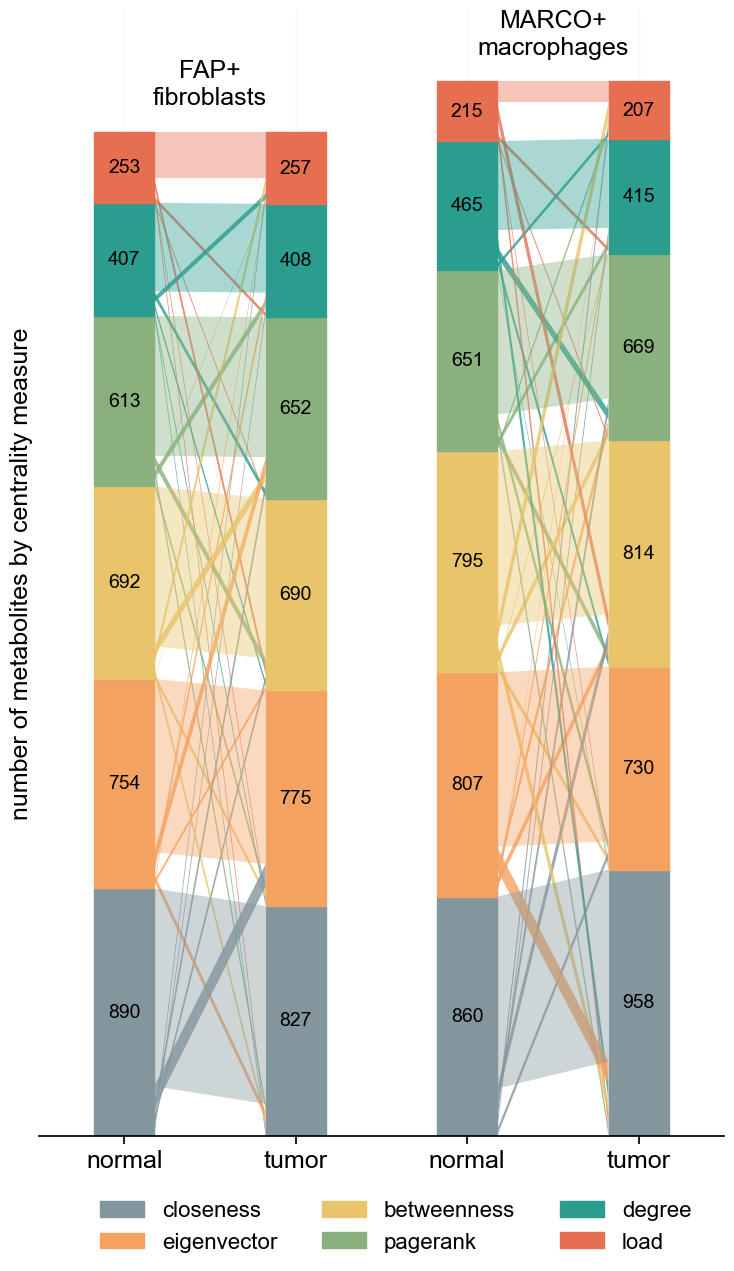

Figure saved: figure5a_sankey_bars


In [4]:
def plot_transition_sankey_stacked_six_bars(classified_df, marker, figsize=(16, 10),  min_flow_percent=3.0):
    # Handle both single marker and list of markers
    if isinstance(marker, str):
        markers = [marker]
    else:
        markers = marker
    
    # Filter data for all specified markers
    plot_df = classified_df[classified_df['Marker'].isin(markers)].copy()
    
    if len(plot_df) == 0:
        print(f"No data found for marker(s): {markers}")
        return None
    
    # Professional color palette
    colors = {
        'load': "#e76f51",      
        'eigenvector': "#f4a261",  
        'betweenness': "#e9c46a",  
        'pagerank': "#8ab17d",     
        'degree': "#2a9d8f",        
        'closeness': "#83969D",  
    }
    
    # Get all unique roles to ensure consistent positioning
    all_roles = set()
    for single_marker in markers:
        marker_df = classified_df[classified_df['Marker'] == single_marker].copy()
        role_transitions = marker_df.groupby(['NormalRole', 'TumorRole']).size().reset_index(name='count')
        all_roles.update(role_transitions['NormalRole'].unique())
        all_roles.update(role_transitions['TumorRole'].unique())
    
    # Calculate combined totals for consistent role ordering
    combined_transitions = plot_df.groupby(['NormalRole', 'TumorRole']).size().reset_index(name='count')
    combined_normal_totals = combined_transitions.groupby('NormalRole')['count'].sum().sort_values(ascending=False)
    combined_tumor_totals = combined_transitions.groupby('TumorRole')['count'].sum().sort_values(ascending=False)
    
    # Find max total for consistent y-axis
    max_total = 0
    for single_marker in markers:
        marker_df = classified_df[classified_df['Marker'] == single_marker].copy()
        marker_total = len(marker_df)
        max_total = max(max_total, marker_total)
    
    # Set up figure
    fig, ax = plt.subplots(figsize=figsize, facecolor='white')
    
    # Create 6 positions (3 Normal, 3 Tumor)
    n_markers = len(markers)
    total_positions = n_markers * 2
    
    ax.set_xlim(-0.5, total_positions - 0.5)
    ax.set_ylim(0, max_total +300)
    
    # Layout parameters
    bar_width = 0.35
    
    # Calculate x positions for each bar
    x_positions = []
    x_labels = []
    
    for i, single_marker in enumerate(markers):
        # Normal position
        normal_x = i * 2
        x_positions.append(normal_x)
        x_labels.append(f'normal')
        
        # Tumor position
        tumor_x = i * 2 + 1
        x_positions.append(tumor_x)
        x_labels.append(f'tumor')
    
    # Function to calculate stacked positions based on role order
    def calculate_stacked_positions_ordered(role_counts, role_order):
        positions = {}
        cumulative_height = 0
        
        for role in role_order:
            if role in role_counts.index:
                count = role_counts[role]
            else:
                count = 0
            
            positions[role] = {
                'y_center': cumulative_height + count/2,
                'y_bottom': cumulative_height,
                'y_top': cumulative_height + count,
                'height': count,
                'count': count
            }
            
            cumulative_height += count
            
        return positions
    
    # Draw stacked segment function
    def draw_stacked_segment(x, y_bottom, width, height, color, role, count):
        if height <= 0:
            return
            
        # Main rectangle
        rect = Rectangle((x - width/2, y_bottom), width, height,
                        facecolor=color, edgecolor=color, linewidth=1, 
                        alpha=1, zorder=2)
        ax.add_patch(rect)
        
        # Add role label and count for significant segments
        if height > max_total * 0.03:  # Only label segments that are 3% or more of max total
            ax.text(x, y_bottom + height/2, f"{int(count)}",  ha='center', va='center', fontsize=14, zorder=3)
    
    # Process each marker and create bars
    for i, single_marker in enumerate(markers):
        marker_df = classified_df[classified_df['Marker'] == single_marker].copy()
        
        if len(marker_df) == 0:
            continue
        
        # Calculate transitions for this marker
        role_transitions = marker_df.groupby(['NormalRole', 'TumorRole']).size().reset_index(name='count')
        
        # Get role counts for normal and tumor
        normal_counts = role_transitions.groupby('NormalRole')['count'].sum()
        tumor_counts = role_transitions.groupby('TumorRole')['count'].sum()
        
        # Calculate positions using consistent role order
        normal_positions = calculate_stacked_positions_ordered(normal_counts, combined_normal_totals.index)
        tumor_positions = calculate_stacked_positions_ordered(tumor_counts, combined_tumor_totals.index)
        
        # Draw normal bar
        normal_x = i * 2
        for role in combined_normal_totals.index:
            pos = normal_positions[role]
            color = colors.get(role.lower(), '#95a5a6')
            draw_stacked_segment(normal_x, pos['y_bottom'], bar_width, pos['height'], 
                               color, role, pos['count'])
        
        # Draw tumor bar  
        tumor_x = i * 2 + 1
        for role in combined_tumor_totals.index:
            pos = tumor_positions[role]
            color = colors.get(role.lower(), '#95a5a6')
            draw_stacked_segment(tumor_x, pos['y_bottom'], bar_width, pos['height'], 
                               color, role, pos['count'])
        
        # Draw flows between normal and tumor bars for this marker
        def create_flow_between_bars(x1, y1_start, y1_end, x2, y2_start, y2_end, color, alpha=0.8):
            """Create a smooth flow between two stacked bar segments"""
            
            # Create smooth curve points
            n_points = 100
            t = np.linspace(0, 1, n_points)
            
            # Bezier curve control points
            ctrl_x = (x1 + x2) / 2
            
            # Top edge curve
            top_x = (1-t)**2 * x1 + 2*(1-t)*t * ctrl_x + t**2 * x2
            top_y = (1-t) * y1_end + t * y2_end
            
            # Bottom edge curve  
            bottom_x = (1-t)**2 * x1 + 2*(1-t)*t * ctrl_x + t**2 * x2
            bottom_y = (1-t) * y1_start + t * y2_start
            
            # Create polygon vertices
            vertices = []
            
            # Top curve (left to right)
            for j in range(len(top_x)):
                vertices.append([top_x[j], top_y[j]])
            
            # Bottom curve (right to left)
            for j in range(len(bottom_x)-1, -1, -1):
                vertices.append([bottom_x[j], bottom_y[j]])
            
            # Create and add polygon
            polygon = Polygon(vertices, facecolor=color, alpha=alpha, edgecolor='none', zorder=1)
            ax.add_patch(polygon)
        
        # Calculate and draw flows between normal and tumor for this marker
        normal_flow_positions = {role: pos['y_bottom'] for role, pos in normal_positions.items()}
        tumor_flow_positions = {role: pos['y_bottom'] for role, pos in tumor_positions.items()}
        
        # Sort flows for better visual layering
        role_transitions_sorted = role_transitions.sort_values('count', ascending=True)
        
        for _, row in role_transitions_sorted.iterrows():
            normal_role = row['NormalRole']
            tumor_role = row['TumorRole']
            count = row['count']
            
            if count == 0:
                continue
            
            # Calculate flow positions within segments
            normal_total = normal_counts.get(normal_role, 0)
            tumor_total = tumor_counts.get(tumor_role, 0)
            
            if normal_total == 0 or tumor_total == 0:
                continue
            
            normal_flow_height = (count / normal_total) * normal_positions[normal_role]['height']
            tumor_flow_height = (count / tumor_total) * tumor_positions[tumor_role]['height']
            
            # Get current flow positions
            normal_y1 = normal_flow_positions[normal_role]
            normal_y2 = normal_y1 + normal_flow_height
            tumor_y1 = tumor_flow_positions[tumor_role]
            tumor_y2 = tumor_y1 + tumor_flow_height
            
            # Update flow positions
            normal_flow_positions[normal_role] = normal_y2
            tumor_flow_positions[tumor_role] = tumor_y2
            
            # Draw flow
            color = colors.get(normal_role.lower(), '#95a5a6')
            x1 = normal_x + bar_width/2
            x2 = tumor_x - bar_width/2
            
            if normal_role == tumor_role:
                create_flow_between_bars(x1, normal_y1, normal_y2, x2, tumor_y1, tumor_y2,  color, alpha=0.4)
            else:
                create_flow_between_bars(x1, normal_y1, normal_y2, x2, tumor_y1, tumor_y2,  color, alpha=0.8)
    
    # Create legend for roles
    legend_elements = []
    for role in combined_normal_totals.index:
        color = colors.get(role.lower(), 'black')
        legend_elements.append(patches.Patch(color=color, label=role.lower()))
    
    #remove box around legend
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.06, -0.04), frameon=False, ncol=3, fontsize=16)
    
    # Set up axes
    ax.set_ylabel('number of metabolites by centrality measure', fontsize=18)
    
    # Set x-axis ticks and labels
    ax.set_xticks(x_positions)
    ax.set_xticklabels(x_labels, fontsize=18)
    
    # Set y-axis ticks
    y_ticks = np.arange(0, max_total + 500, 500)
    ax.set_yticks([])
    #ax.set_yticklabels([f'{int(y)}' for y in y_ticks])
    ax.set_ylim(0, 4050)
    # Add subtle grid
    #ax.grid(x=False,y=True)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # Add top text for bars
    for i, marker in enumerate(markers):
        normal_x = 0.5 + i * 2
        tumor_x = i * 2 + 1
        if marker == 'FAP+':
            celltype = 'fibroblasts'
        elif marker == 'MARCO+':  
            celltype = 'macrophages'
            max_total+=180
        ax.text(normal_x, max_total-100, f'{marker}\n{celltype}', ha='center', va='bottom', fontsize=18)
    
    plt.tight_layout()
    plt.show()

    save_figure(fig, 'figure5a_sankey_bars')

    return fig

fig5a = plot_transition_sankey_stacked_six_bars(metabolites_classified, 
                                                marker=['FAP+', 'MARCO+'], 
                                                figsize=(8, 13),
                                                min_flow_percent=3.0
                                            )

##### **(B)** Transition matrices quantifying role changes for FAP+ fibroblasts (left, 3,609 metabolites) and MARCO+ macrophages (right, 3,793 metabolites).

Figure saved: figure5b_transition_heatmap_FAP+
Figure saved: figure5b_transition_heatmap_MARCO+


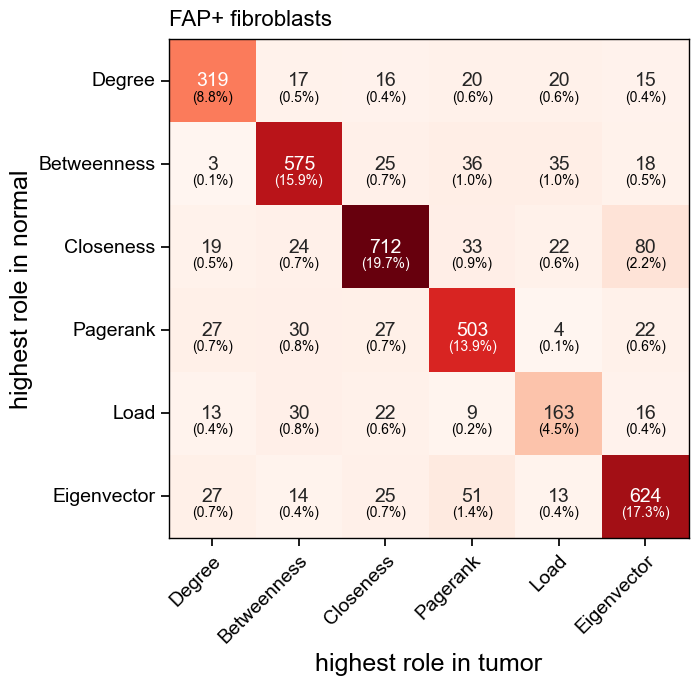

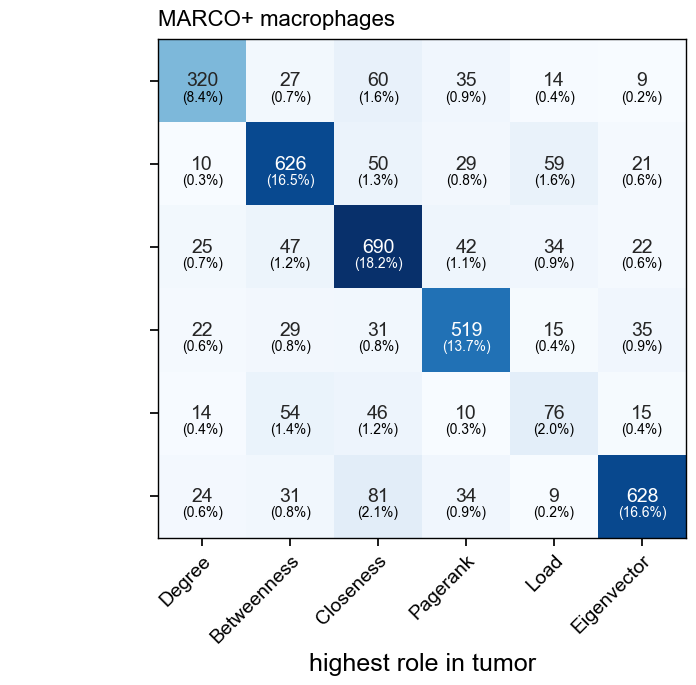

In [5]:
def plot_transition_heatmap(classified_df, marker, figsize=(12, 10),cmap='Blues', drawbarplots=False):
    
    # Filter data for the specified marker
    marker_df = classified_df[classified_df['Marker'] == marker].copy()
    
    # Define all possible roles
    roles = ['Degree', 'Betweenness', 'Closeness', 'Pagerank', 'Load', 'Eigenvector']
    #roles = ['Connectivity', 'Bottleneck', 'Reachability', 'Prominence', 'Capacity', 'Centrality']
    
    # Create a matrix for the heatmap
    transition_matrix = np.zeros((len(roles), len(roles)))
    
    # Calculate transitions from the DataFrame 
    transitions = marker_df.groupby(['NormalRole', 'TumorRole']).size().reset_index(name='count')
    transitions_dict = {(row['NormalRole'], row['TumorRole']): {'count': row['count']} 
                    for _, row in transitions.iterrows()}

    # Then iterate through the transitions
    for (normal_role, tumor_role), data in transitions_dict.items():
        normal_idx = roles.index(normal_role)
        tumor_idx = roles.index(tumor_role)
        transition_matrix[normal_idx, tumor_idx] = data['count']
    
    # Calculate marginal sums
    row_sums = transition_matrix.sum(axis=1)  # Normal tissue roles
    col_sums = transition_matrix.sum(axis=0)  # Tumor tissue roles
    total_metabolites = np.sum(row_sums)
    
    # Create a figure with GridSpec
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(4, 4, figure=fig, wspace=0, hspace=0)
    
    # Create axes for the heatmap and marginal plots
    ax_heatmap = fig.add_subplot(gs[1:4, 0:3])
    
    # Draw the heatmap
    sns.heatmap(transition_matrix, annot=True, fmt=".0f", cmap=cmap, annot_kws={"fontsize": 14},
               xticklabels=roles, yticklabels=roles, ax=ax_heatmap,
               cbar=False)
    

    # Add a border around the heatmap
    for spine in ax_heatmap.spines.values():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)  # Adjust thickness as needed
    
    # Add percentage annotations to heatmap
    for i in range(len(roles)):
        for j in range(len(roles)):
            if transition_matrix[i, j] > 0:
                percentage = (transition_matrix[i, j] / total_metabolites) * 100
                # Use white text for dark cells, black for light cells
                text_color = "white" if transition_matrix[i, j] > np.max(transition_matrix)/2 else "black"
                ax_heatmap.text(j + 0.5, i + 0.5 + 0.2, f"({percentage:.1f}%)", fontsize=10,
                               ha="center", va="center", color=text_color)
     
    # Draw the barplots
    if drawbarplots:
        ax_barx = fig.add_subplot(gs[0, 0:3], sharex=ax_heatmap)
        ax_bary = fig.add_subplot(gs[1:4, 3], sharey=ax_heatmap)
        # Tumor distribution (x-axis)
        barx = ax_barx.bar(np.arange(len(roles)) + 0.5, col_sums, width=0.6, 
                        color='Gray')
        
        # Normal distribution (y-axis) - horizontally flipped
        bary = ax_bary.barh(np.arange(len(roles)) + 0.5, row_sums, height=0.6, 
                        color='Gray')
        
        # Add percentage labels to the bar plots
        for i, count in enumerate(col_sums):
            if count > 0:
                percentage = (count / total_metabolites) * 100
                ax_barx.text(i + 0.5, count + (np.max(col_sums) * 0.02), 
                        f"{count:.0f}\n({percentage:.1f}%)", ha='center', va='bottom', fontsize=9)
        
        for i, count in enumerate(row_sums):
            if count > 0:
                percentage = (count / total_metabolites) * 100
                ax_bary.text(count + (np.max(row_sums) * 0.02), i + 0.5, 
                            f"{count:.0f}\n({percentage:.1f}%)", ha='left', va='center', fontsize=9)
        ax_barx.set_ylabel('count', )
        ax_bary.set_xlabel('count', )
        # Hide tick labels on marginal plots
        ax_barx.tick_params(axis='x', labelbottom=False)
        ax_bary.tick_params(axis='y', labelleft=False)
        # Remove spines
        ax_barx.spines[['right', 'top', 'left']].set_visible(False)
        ax_bary.spines[['right', 'top', 'bottom']].set_visible(False)
        # Clean up axes
        ax_barx.set_yticks(ax_barx.get_yticks())
        ax_barx.set_ylim(0, ax_barx.get_ylim()[1] * 1.15)  # Add some space for percentage labels
        ax_bary.set_xticks(ax_bary.get_xticks())
        ax_bary.set_xlim(0, ax_bary.get_xlim()[1] * 1.15)  # Add some space for percentage labels
        
    # Set labels and titles
    ax_heatmap.set_xlabel('highest role in tumor', fontsize=18)
    if marker == 'FAP+':
        ax_heatmap.set_ylabel('highest role in normal', fontsize=18)
    else: #remove yticks
        ax_heatmap.set_yticklabels('')
        ax_heatmap.set_ylabel(' \n \n \n \n')
    
    # Rotate x-axis labels for better readability
    plt.setp(ax_heatmap.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

    # Add title to top left of heatmap
    if marker == 'FAP+': celltype = 'fibroblasts'
    elif marker == 'MARCO+':   celltype = 'macrophages'
    ax_heatmap.set_title(f'{marker} {celltype}', fontsize=16, pad=10, loc='left')
    
    plt.tight_layout()

    save_figure(fig, 'figure5b_transition_heatmap_' + marker)
 
    return fig, transition_matrix

fig5bFAP, transition_matrix_FAP = plot_transition_heatmap(metabolites_classified, marker='FAP+', figsize=(9, 8.5), cmap='Reds')
fig5bMARCO, transition_matrix_MARCO = plot_transition_heatmap(metabolites_classified, marker='MARCO+', figsize=(9, 8.5), cmap='Blues')

##### **(C)**  Subsystem analysis of eigenvector-to-betweenness transition metabolites, showing metabolic pathways that create new bottleneck control points. Pie charts display the distribution of transition metabolites across metabolic subsystems for FAP+ fibroblasts (left) and MARCO+ macrophages (right). Bar plots show the number of metabolites in each subsystem category. 

In [6]:
def processMetaboliteTransitions(classified_df, marker, normal_role, tumor_role, 
                           min_subsystem_percent=0, skiptransport=False): 
    # Filter data for the specified transition
    transition_df = classified_df[
        (classified_df['Marker'] == marker) &
        (classified_df['NormalRole'] == normal_role) &
        (classified_df['TumorRole'] == tumor_role)
    ].copy()
    
    # Check if we have data
    if len(transition_df) == 0:
        print(f"No data found for marker={marker}, normal_role={normal_role}, tumor_role={tumor_role}")
        return None
    
    # Count metabolites in this transition
    total_metabolites = len(transition_df)
    print(f"Found {total_metabolites} metabolites transitioning from {normal_role} to {tumor_role} in {marker}")
    
    # Create a name for other subsystems
    others_name = f'Other subsystems (<{min_subsystem_percent}%)'
    
    # Check if subsystem data is available
    has_subsystem_data = 'SubsystemDetails' in transition_df.columns
    
    if not has_subsystem_data:
        print("No SubsystemDetails found in the DataFrame")
        return None
    
    # Count subsystems
    subsystem_counter = Counter()
    
    # Dictionary to track which metabolites belong to which subsystems
    subsystem_metabolites = {}
    
    # Process each metabolite
    for _, row in transition_df.iterrows():
        if isinstance(row.get('SubsystemDetails'), dict):
            for subsystem, count in row['SubsystemDetails'].items():
                if skiptransport and subsystem.lower() == 'transport reactions':
                    continue
                
                subsystem_counter[subsystem] += count
                
                # Track the metabolite in this subsystem
                if subsystem not in subsystem_metabolites:
                    subsystem_metabolites[subsystem] = []
                
                # Add the metabolite name (with count if applicable)
                metabolite_entry = {
                    'name': row['MetaboliteName'],
                    'count': count,
                    'id': row.get('MetaboliteID', '')
                }
                subsystem_metabolites[subsystem].append(metabolite_entry)
    
    # Calculate total subsystem counts
    total_subsystems = sum(subsystem_counter.values())
    
    # Filter subsystems based on threshold
    filtered_subsystems = []
    other_subsystems_data = []
    
    for subsystem, count in subsystem_counter.items():
        percentage = (count / total_subsystems) * 100 if total_subsystems > 0 else 0
        if percentage >= min_subsystem_percent:
            filtered_subsystems.append({
                'name': subsystem,
                'count': count,
                'percentage': percentage,
                'metabolites': subsystem_metabolites.get(subsystem, [])
            })
        else:
            other_subsystems_data.append({
                'name': subsystem,
                'count': count,
                'percentage': percentage,
                'metabolites': subsystem_metabolites.get(subsystem, [])
            })
    
    # Add "Other subsystems" if needed
    other_count = sum(item['count'] for item in other_subsystems_data)
    if other_count > 0:
        other_percentage = (other_count / total_subsystems) * 100 if total_subsystems > 0 else 0
        if other_percentage >= min_subsystem_percent:
            # Collect all metabolites from other subsystems
            other_metabolites = []
            for item in other_subsystems_data:
                other_metabolites.extend(item['metabolites'])
            
            filtered_subsystems.append({
                'name': others_name,
                'count': other_count,
                'percentage': other_percentage,
                'metabolites': other_metabolites
            })
    
    # Sort subsystems by count
    filtered_subsystems.sort(key=lambda x: x['count'], reverse=True)
    
    return {
        'transition_df': transition_df,
        'filtered_subsystems': filtered_subsystems,
        'total_metabolites': total_metabolites,
        'others_name': others_name,
        'marker': marker,
        'normal_role': normal_role,
        'tumor_role': tumor_role
    }


def createSubsystemColors(filtered_subsystems, subsystem_colors_dict=None, others_name=None): 
    if subsystem_colors_dict is None:
        subsystem_colors_dict = {}
        
    # Get colormap colors
    cmap_list = ['tab20', 'tab20b']
    all_colors = []
    for cmap_name in cmap_list:
        current_cmap = plt.get_cmap(cmap_name)
        n_colors = getattr(current_cmap, 'N', 10)
        all_colors.extend([current_cmap(i) for i in range(n_colors)])
    
    # Ensure we have enough colors
    while len(all_colors) < len(filtered_subsystems):
        all_colors.extend(all_colors)
    
    # Assign colors
    for i, subsystem_data in enumerate(filtered_subsystems):
        subsystem = subsystem_data['name']
        if subsystem not in subsystem_colors_dict:
            if subsystem == others_name:
                subsystem_colors_dict[subsystem] = '#e8e8e8'  # Light gray for "Other subsystems"
            else:
                subsystem_colors_dict[subsystem] = all_colors[i]
    
    return subsystem_colors_dict


def plotSubsystemPieChart(data_dict, subsystem_colors_dict=None, figsize=(10, 8), 
                            show_legend=True, save_name=None):

    filtered_subsystems = data_dict['filtered_subsystems']
    marker = data_dict['marker']
    normal_role = data_dict['normal_role']
    tumor_role = data_dict['tumor_role']
    total_metabolites = data_dict['total_metabolites']
    others_name = data_dict.get('others_name')
    
    # Create colors if not provided
    subsystem_colors_dict = createSubsystemColors(
        filtered_subsystems, 
        subsystem_colors_dict, 
        others_name
    )
    
    # Create pie chart
    fig, ax_pie = plt.subplots(figsize=figsize)
    
    # Extract data for the pie chart
    labels = [item['name'] for item in filtered_subsystems]
    sizes = [item['count'] for item in filtered_subsystems]
    colors = [subsystem_colors_dict.get(label, '#1f77b4') for label in labels]
    
    # Draw the pie chart
    wedges, texts, autotexts = ax_pie.pie(
        sizes, 
        labels=None,  # We'll add legend instead
        autopct='%1.1f%%',
        startangle=90,
        colors=colors,
        wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
    )
    
    # Add some styling to percentage text
    for autotext in autotexts:
        autotext.set_text('')
        autotext.set_color('white')
        autotext.set_fontsize(10)
        autotext.set_weight('bold')
    
    # Add legend if requested
    if show_legend:
        legend_labels = [f"{item['name']} ({item['count']})" for item in filtered_subsystems]
        ax_pie.legend(wedges, legend_labels, loc="center left", 
                     bbox_to_anchor=(1, 0.5), frameon=False, fontsize=14)
    
    # Equal aspect ratio ensures that pie is drawn as a circle
    ax_pie.set_aspect('equal')
    
    # Adjust layout
    plt.tight_layout()
    
    if save_name:
        save_figure(fig, save_name)
    
    return fig, ax_pie, subsystem_colors_dict


def plotSubsystemLegend(data_dict, subsystem_colors_dict, figsize=(6, 4), save_name=None):
    filtered_subsystems = data_dict['filtered_subsystems']
    # Create figure for legend only
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis('off')
    
    # Create legend handles with square markers
    handles = []
    labels = []
    
    for item in filtered_subsystems:
        subsystem = item['name']
        count = item['count']
        color = subsystem_colors_dict.get(subsystem, '#1f77b4')
        
        # Create a square marker using Rectangle patch
        square = patches.Rectangle((0, 0), 1, 1, facecolor=color)
        handles.append(square)
        labels.append(f"{subsystem} ({count})")
    
    # Add legend with square markers
    legend = ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 1), frameon=False, 
                       fontsize=14, ncol=1,
                       handlelength=1,  # Makes the marker square
                       handleheight=1,
                       labelspacing=0.3)  # Makes the marker square
    
    plt.tight_layout()
    
    if save_name:
        save_figure(fig, save_name)
    
    return fig, ax


def prepareMetaboliteBars(transition_df, skiptransport=False):
    metabolite_names = []
    subsystem_data = {}
    metabolite_total_counts = []
    metabolite_ids = []
    
    # First pass: collect all subsystems and initialize data structure
    all_subsystems = set()
    for _, row in transition_df.iterrows():
        if isinstance(row.get('SubsystemDetails'), dict):
            for subsystem in row['SubsystemDetails'].keys():
                if not (skiptransport and subsystem.lower() == 'transport reactions'):
                    all_subsystems.add(subsystem)
    
    # Initialize subsystem data dictionary
    for subsystem in all_subsystems:
        subsystem_data[subsystem] = []
    
    # Process each metabolite
    for _, row in transition_df.iterrows():
        name = row['MetaboliteName']
        met_id = row.get('MetaboliteID', '')
        label = name if len(name) < 40 else name[:36] + '...'
        if met_id:
            label += f" ({met_id[-1]})"
        metabolite_names.append(label)
        metabolite_ids.append(met_id)
        
        # Add subsystem information
        total_count = 0
        if isinstance(row.get('SubsystemDetails'), dict):
            # Fill data for bar plot
            for subsystem in all_subsystems:
                count = row.get('SubsystemDetails', {}).get(subsystem, 0)
                if skiptransport and subsystem.lower() == 'transport reactions':
                    count = 0
                subsystem_data[subsystem].append(count)
                total_count += count
        else:
            # No subsystem data for this metabolite
            for subsystem in all_subsystems:
                subsystem_data[subsystem].append(0)
        
        metabolite_total_counts.append(total_count)
    
    return {
        'metabolite_names': metabolite_names,
        'subsystem_data': subsystem_data,
        'metabolite_total_counts': metabolite_total_counts,
        'metabolite_ids': metabolite_ids
    }


def plotMetaboliteBars(bar_data, subsystem_colors_dict, 
                               figsize=(12, 4), show_legend=False, 
                               marker_name=None, save_name=None):
    metabolite_names = bar_data['metabolite_names']
    subsystem_data = bar_data['subsystem_data']
    metabolite_total_counts = bar_data['metabolite_total_counts']
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    if metabolite_names:
        # Sort all data by total counts for better visualization
        if len(metabolite_names) > 1:  # Only sort if there's more than one metabolite
            sorted_indices = np.argsort(metabolite_total_counts)[::-1]  # Descending order
            metabolite_names = [metabolite_names[i] for i in sorted_indices]
            for subsystem in subsystem_data:
                subsystem_data[subsystem] = [subsystem_data[subsystem][i] for i in sorted_indices]
            metabolite_total_counts = [metabolite_total_counts[i] for i in sorted_indices]
        
        # Setup bar plot
        bottom = np.zeros(len(metabolite_names))
        bar_width = 0.8
        
        # Sort subsystems by total count for consistent coloring with pie chart
        subsystem_totals = {subsys: sum(counts) for subsys, counts in subsystem_data.items()}
        sorted_subsystems = sorted(subsystem_totals.items(), key=lambda x: x[1], reverse=True)
        
        # Draw the stacked bars
        handles = []  # For the legend
        labels = []   # For the legend
        for subsystem, _ in sorted_subsystems:
            counts = subsystem_data[subsystem]
            if sum(counts) > 0:  # Only plot non-zero subsystems
                color = subsystem_colors_dict.get(subsystem, '#1f77b4')
                bars = ax.bar(
                    range(len(metabolite_names)), 
                    counts, 
                    bar_width, 
                    bottom=bottom, 
                    color=color, 
                    edgecolor='white',
                    linewidth=0.5
                )
                bottom += counts
                # Add to legend
                handles.append(patches.Patch(color=color))
                labels.append(subsystem)
        
        # Set x-axis labels and title
        ax.set_xticks(range(len(metabolite_names)))
        ax.set_xticklabels(metabolite_names, rotation=90, ha='center')
        ax.set_ylabel("subsystem count", fontsize=18)
        if marker_name == 'MARCO+':
           ax.set_ylabel("\n", fontsize=18)

        ax.grid(True)
        
        # Increase y axis lim by 1
        ax.set_ylim(0, max(bottom) + 1)
        
        # Add legend if requested
        if show_legend:
            ax.legend(handles, labels, loc='upper right', frameon=False)
    
    plt.tight_layout()
    
    save_figure(fig, save_name)
    
    return fig, ax


# Main wrapper function that calls all the separate functions
def createPlotsSeperately(classified_df, marker, normal_role, tumor_role, 
                    subsystem_colors_dict=None, 
                    pie_figsize=(10, 8),
                    bar_figsize=(12, 4),
                    legend_figsize=(6, 4),
                    min_subsystem_percent=0, 
                    skiptransport=False,
                    save_prefix=None):
    
    # Process the data
    data_dict = processMetaboliteTransitions(
        classified_df, marker, normal_role, tumor_role,
        min_subsystem_percent=min_subsystem_percent,
        skiptransport=skiptransport
    )
    
    if data_dict is None:
        return None
    
    # Create subsystem colors
    subsystem_colors_dict = createSubsystemColors(
        data_dict['filtered_subsystems'], 
        subsystem_colors_dict,
        data_dict['others_name']
    )
    
    # Create pie chart (without legend)
    pie_save = f"{save_prefix}_pie_{marker}" if save_prefix else None
    pie_fig, pie_ax, colors = plotSubsystemPieChart(
        data_dict, 
        subsystem_colors_dict,
        figsize=pie_figsize,
        show_legend=False,
        save_name=pie_save
    )
    
    # Create standalone legend
    legend_save = f"{save_prefix}_legend_{marker}" if save_prefix else None
    legend_fig, legend_ax = plotSubsystemLegend(
        data_dict,
        subsystem_colors_dict,
        figsize=legend_figsize,
        save_name=legend_save
    )
    
    # Prepare bar data
    bar_data = prepareMetaboliteBars(
        data_dict['transition_df'],
        skiptransport=skiptransport
    )
    
    # Create stacked bar plot
    bar_save = f"{save_prefix}_bar_{marker}" if save_prefix else None
    bar_fig, bar_ax = plotMetaboliteBars(
        bar_data,
        subsystem_colors_dict,
        figsize=bar_figsize,
        show_legend=False,
        marker_name=marker,
        save_name=bar_save
    )
    
    return {
        'pie': (pie_fig, pie_ax),
        'bar': (bar_fig, bar_ax),
        'legend': (legend_fig, legend_ax),
        'colors': subsystem_colors_dict,
        'data': data_dict
    }

Found 14 metabolites transitioning from Eigenvector to Betweenness in FAP+
Figure saved: figure5c_subsystem_pie_FAP+
Figure saved: figure5c_subsystem_legend_FAP+
Figure saved: figure5c_subsystem_bar_FAP+
Found 31 metabolites transitioning from Eigenvector to Betweenness in MARCO+
Figure saved: figure5c_subsystem_pie_MARCO+
Figure saved: figure5c_subsystem_legend_MARCO+
Figure saved: figure5c_subsystem_bar_MARCO+


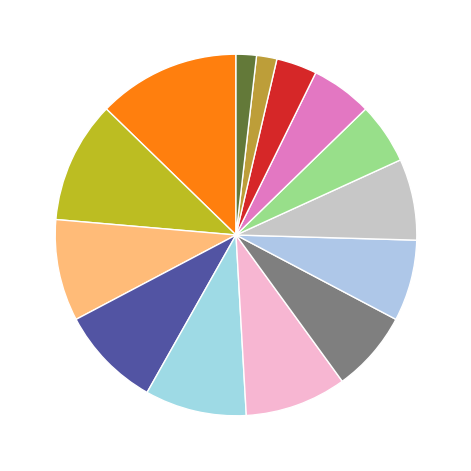

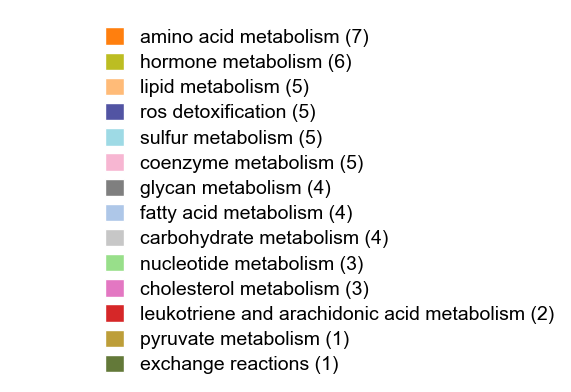

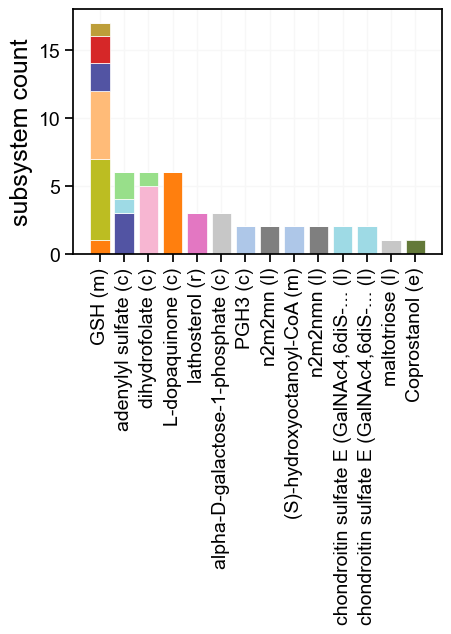

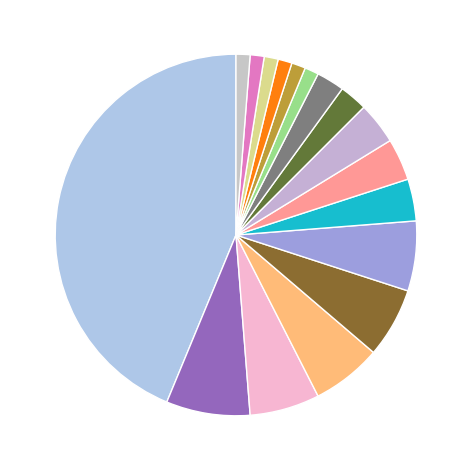

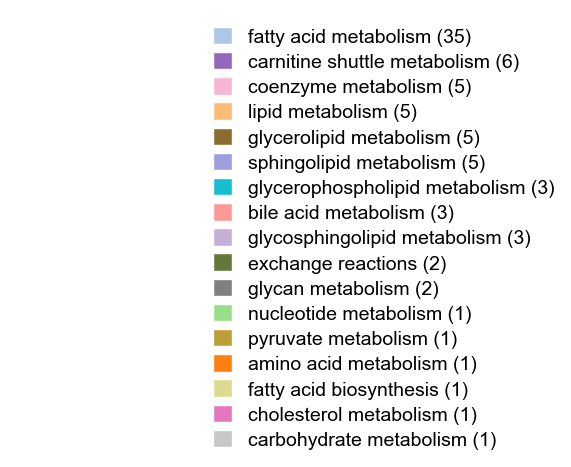

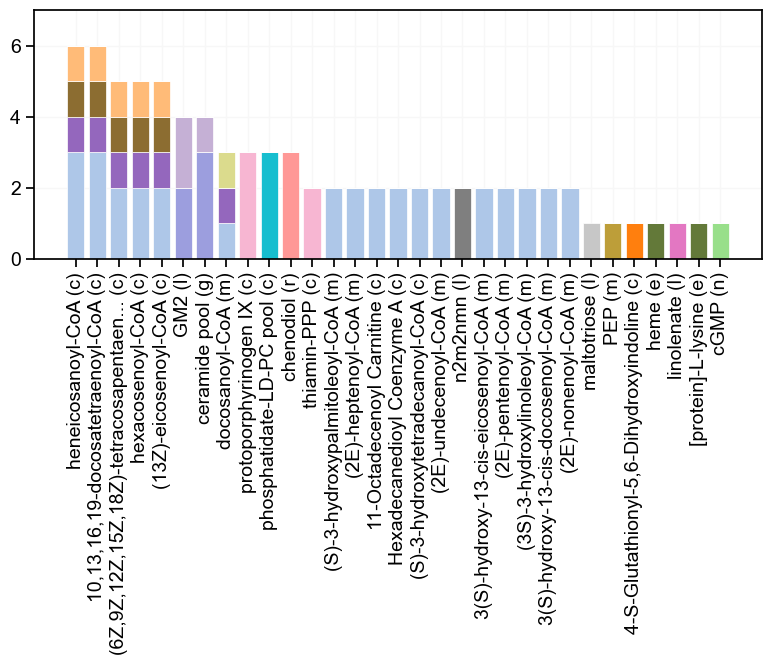

In [7]:
# For FAP+ transition
fap_results = createPlotsSeperately(
    metabolites_classified, 
    marker='FAP+', 
    normal_role='Eigenvector', 
    tumor_role='Betweenness',
    subsystem_colors_dict=subsystem_colors,
    pie_figsize=(12, 5),
    bar_figsize=(4.8, 6.7),
    legend_figsize=(6, 4),
    min_subsystem_percent=0,
    skiptransport=True,
    save_prefix='figure5c_subsystem'
)

# For MARCO+ transition
marco_results = createPlotsSeperately(
    metabolites_classified,
    marker='MARCO+',
    normal_role='Eigenvector',
    tumor_role='Betweenness',
    subsystem_colors_dict=subsystem_colors,
    pie_figsize=(12, 5),
    bar_figsize=(8, 7),
    legend_figsize=(6, 4),
    min_subsystem_percent=0,
    skiptransport=True,
    save_prefix='figure5c_subsystem'
)
    

##### **(D)** Analysis of extracellular metabolite role transitions revealing intercellular communication networks.

Found 15 extracellular crosstalk metabolites
Figure saved: figure5d_transition_exchange_mets


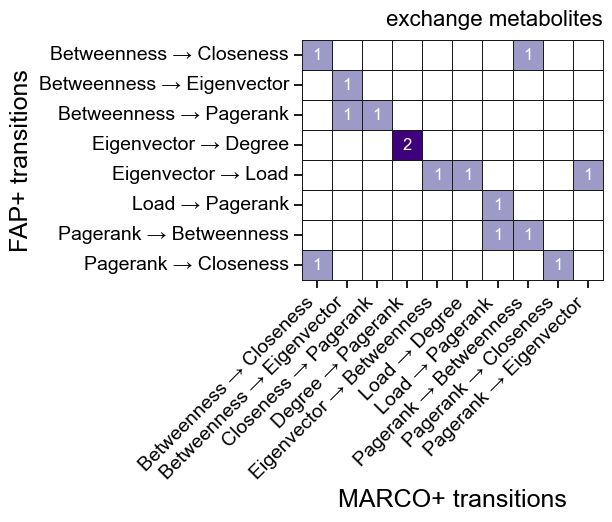

In [8]:
def plotPotentialCrosstalkMetsMatrix(metabolites_classified, figsize=(12, 10), save_plots=False):
    markers = ['FAP+', 'MARCO+']
    
    # Filter data for extracellular metabolites with transitions
    data = metabolites_classified[
        (metabolites_classified['Marker'].isin(markers)) &
        (metabolites_classified['NormalRole'] != metabolites_classified['TumorRole']) &
        (metabolites_classified['MetaboliteID'].str.endswith('e', na=False))
    ].copy()
    
    if len(data) == 0:
        print("No extracellular metabolite transition data found")
        return {}
    
    # Find crosstalk metabolites
    metabolite_transitions = defaultdict(list)
    
    for _, row in data.iterrows():
        met_name = row['MetaboliteName']
        metabolite_transitions[met_name].append({
            'marker': row['Marker'],
            'normal_role': row['NormalRole'],
            'tumor_role': row['TumorRole'],
            'transition': f"{row['NormalRole']} → {row['TumorRole']}"
        })
    
    # Filter for true crosstalk (present in both cell types)
    crosstalk_metabolites = {}
    for met_name, transitions in metabolite_transitions.items():
        markers_involved = set(t['marker'] for t in transitions)
        if len(markers_involved) == 2 and markers_involved == set(markers):
            crosstalk_metabolites[met_name] = transitions
    
    if len(crosstalk_metabolites) == 0:
        print("No crosstalk metabolites found!")
        return {}
    
    print(f"Found {len(crosstalk_metabolites)} extracellular crosstalk metabolites")
    
    # Create transition matrix with metabolite names
    matrix_data = defaultdict(lambda: defaultdict(list))
    
    for met_name, transitions in crosstalk_metabolites.items():
        fap_transition = next(t['transition'] for t in transitions if t['marker'] == 'FAP+')
        marco_transition = next(t['transition'] for t in transitions if t['marker'] == 'MARCO+')
        
        matrix_data[fap_transition][marco_transition].append(met_name)
    
    # Get all unique transitions
    all_fap_transitions = set(matrix_data.keys())
    all_marco_transitions = set()
    for marco_dict in matrix_data.values():
        all_marco_transitions.update(marco_dict.keys())
    
    # Sort transitions for better display
    all_fap_transitions = sorted(all_fap_transitions)
    all_marco_transitions = sorted(all_marco_transitions)
    
    # Create DataFrame for seaborn heatmap
    count_matrix = np.zeros((len(all_fap_transitions), len(all_marco_transitions)))
    
    for i, fap_trans in enumerate(all_fap_transitions):
        for j, marco_trans in enumerate(all_marco_transitions):
            if marco_trans in matrix_data[fap_trans]:
                count_matrix[i, j] = len(matrix_data[fap_trans][marco_trans])
    
    # Create DataFrame
    df_matrix = pd.DataFrame(
        count_matrix,
        index=all_fap_transitions,
        columns=all_marco_transitions
    )
    
    # Create annotations matrix
    annot_matrix = np.empty((len(all_fap_transitions), len(all_marco_transitions)), dtype=object)
    
    for i, fap_trans in enumerate(all_fap_transitions):
        for j, marco_trans in enumerate(all_marco_transitions):
            if marco_trans in matrix_data[fap_trans]:
                metabolites = matrix_data[fap_trans][marco_trans]
                
                text = metabolites[0]
                annot_matrix[i, j] = text
            else:
                annot_matrix[i, j] = ""

    # Create the seaborn heatmap
    fig = plt.figure(figsize=figsize)
    
    df_matrix_annot = df_matrix.replace(0, np.nan)  
    # Create heatmap with seaborn
    ax = sns.heatmap(
        df_matrix_annot,
        annot=True,
        fmt='.0f',  # Don't format annotations as numbers
        cmap='Purples',
        # hide cbar for cleaner look
        cbar=False,
        square=True,
        linewidths=.5,
        linecolor='k',
        clip_on = False,
        vmin=0, 
        annot_kws={'fontsize': 12}
    )
    
    # Customize the plot
    ax.set_xlabel('MARCO+ transitions', fontsize=18)
    ax.set_ylabel('FAP+ transitions', fontsize=18)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    plt.grid(False)

    # Add title to top right "exchange metabolits"
    ax.set_title('exchange metabolites', fontsize=16, pad=10, loc='right')
    
    # Adjust layout
    plt.tight_layout()
    
    save_figure(fig, 'figure5d_transition_exchange_mets')
    plt.show()
    
    return annot_matrix

# Call the function
annot_matrix = plotPotentialCrosstalkMetsMatrix(metabolites_classified, figsize=(8, 5.5), save_plots=False)

Figure saved: Figure5_Role_Transitions


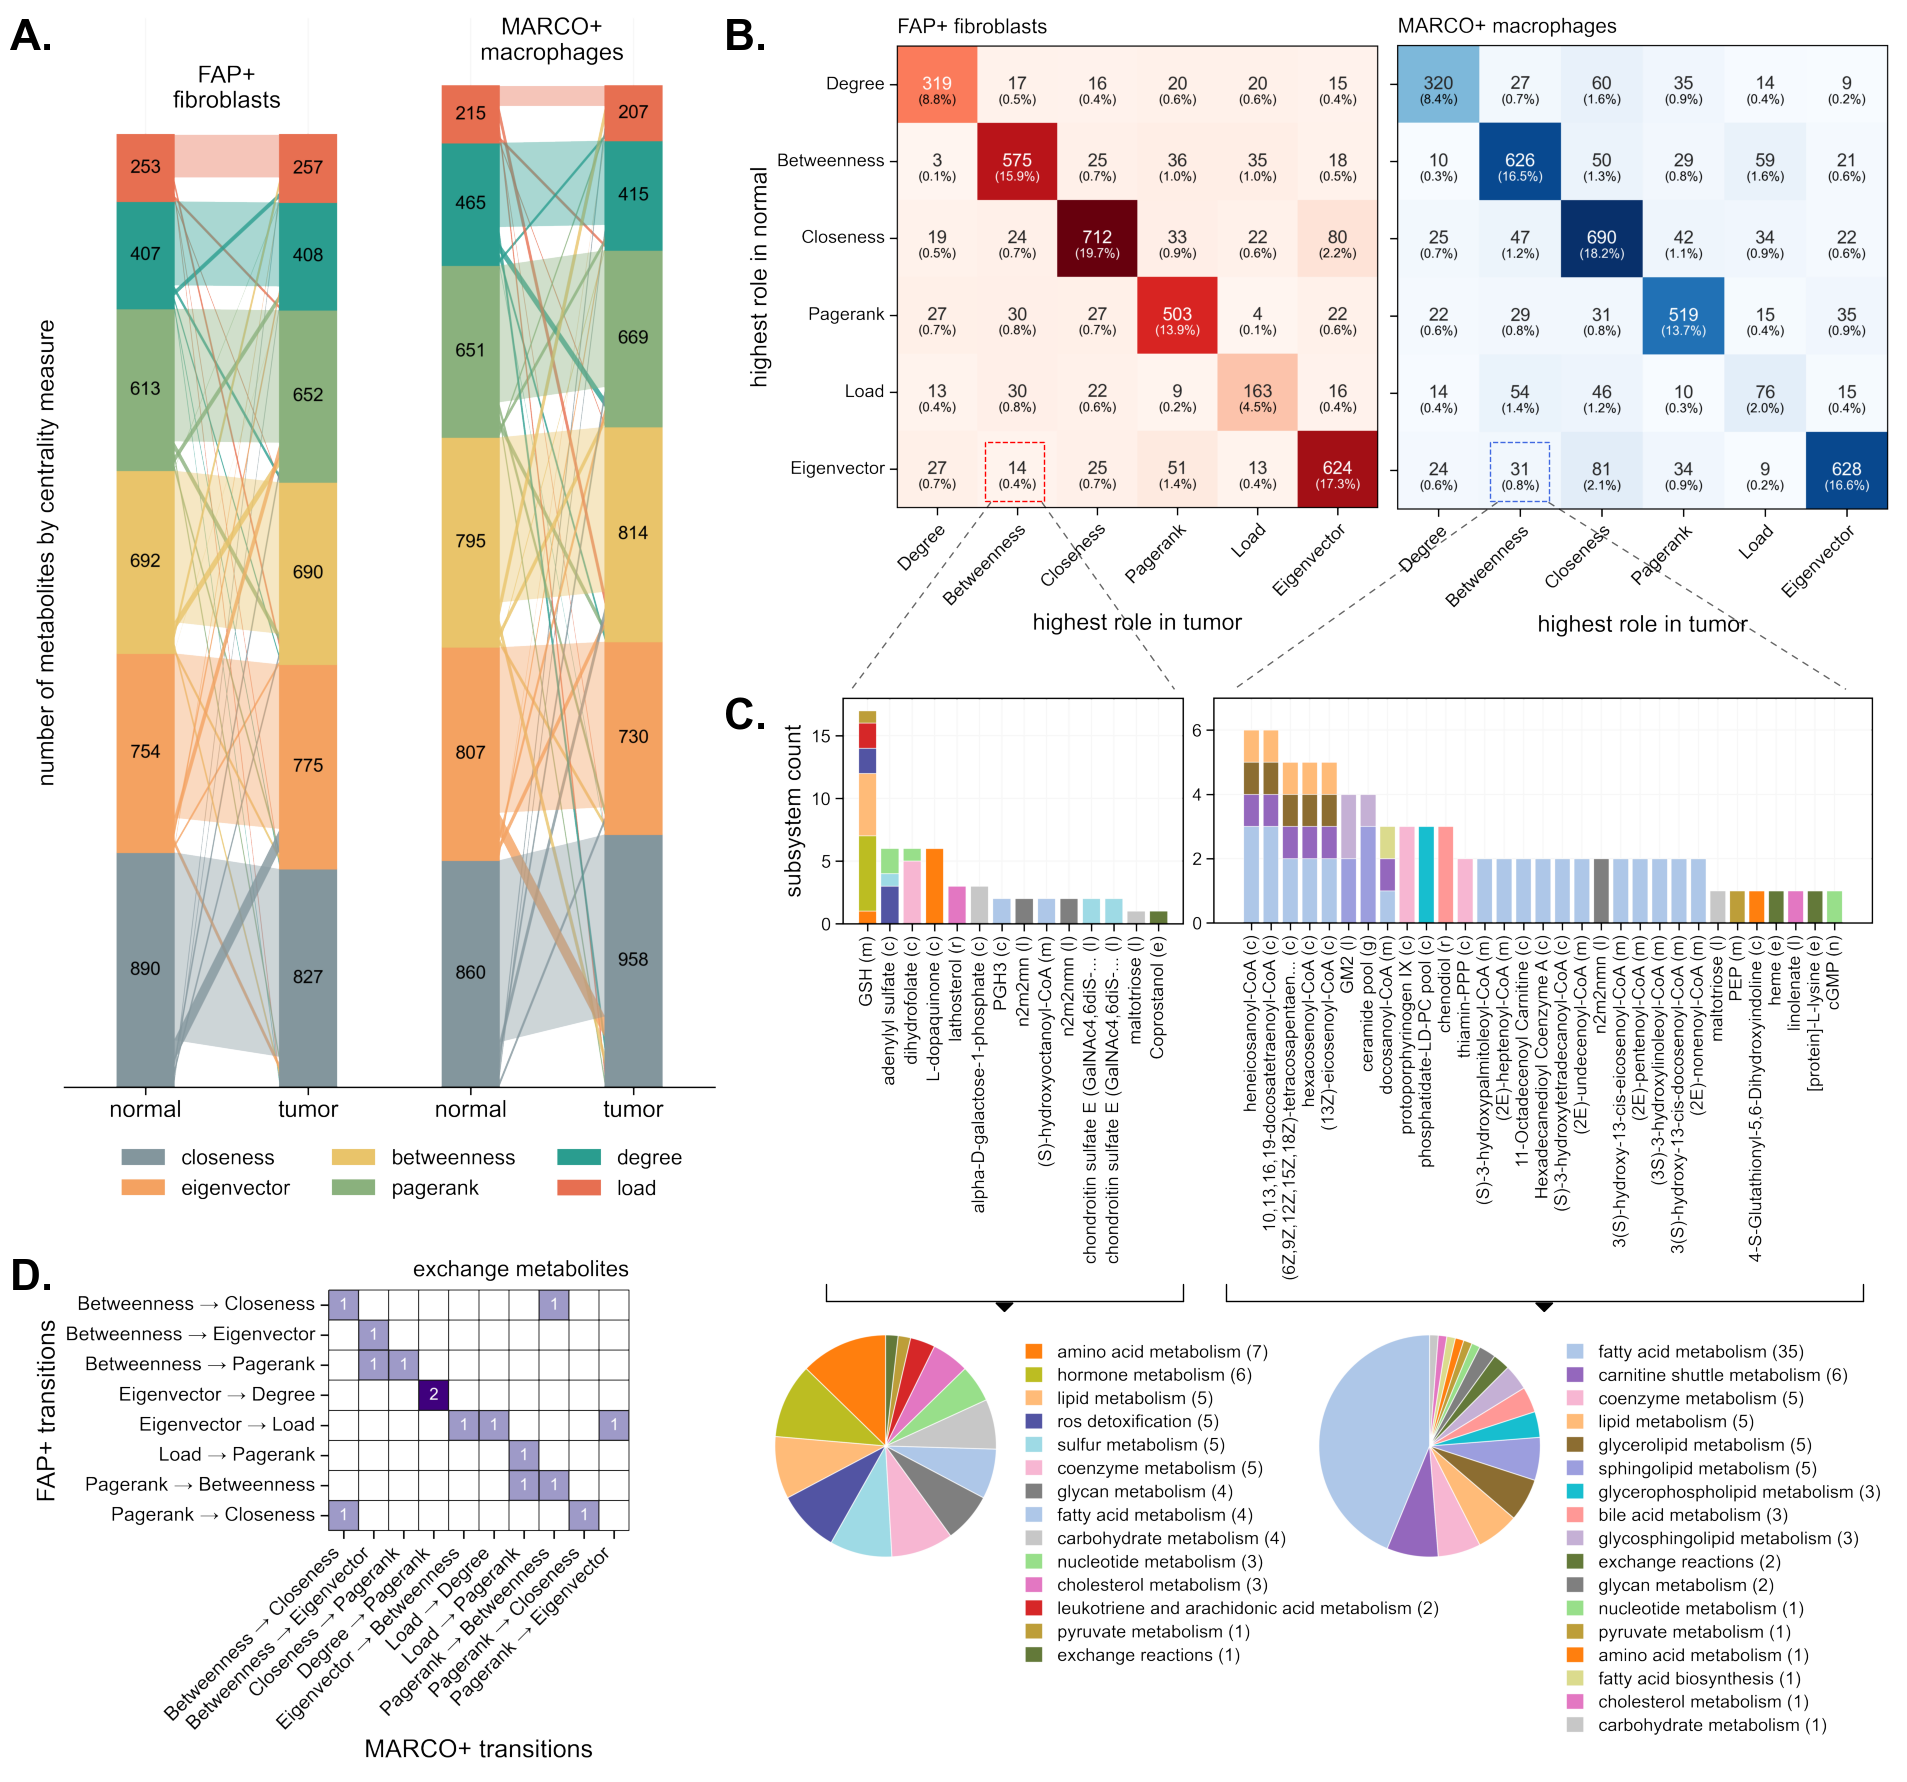

In [9]:


fig = plt.figure(figsize=(17, 17))
def add_panel(image_path, xyw, label=None, z=1):
    x, y, w = xyw
    # Read image to get aspect ratio
    img = mpimg.imread(image_path)
    img_h, img_w = img.shape[:2]
    aspect_ratio = img_h / img_w
    h = w * aspect_ratio  # scale height to keep image ratio
    bottom = 1 - y - h # Convert y from top-left origin to bottom-left origin
    ax = fig.add_axes([x, bottom, w, h], zorder=z)
    ax.imshow(img)
    ax.axis("off")
    if label:
        if label == 'C': x -= 0.02
        fig.text(x-0.01, bottom + h -0.005, label +'. ', fontsize=31, ha='left', va='top', fontweight='bold')

add_panel("../figures/png/figure5a_sankey_bars.png",               [0, 0, .41],    "A")

add_panel("../figures/png/figure5b_transition_heatmap_FAP+.png",   [.42, 0, .38],     "B")
add_panel("../figures/png/figure5b_transition_heatmap_MARCO+.png", [.72, 0, .38],     "")



add_panel("../figures/png/figure5c_subsystem_bar_FAP+.png", [.44, .4, .245],    "C")
add_panel("../figures/png/figure5c_subsystem_bar_MARCO+.png", [.68, .4, .41],    "")

add_panel("../figures/png/figure5c_subsystem_pie_FAP+.png", [.42, .76, .17],    "")
add_panel("../figures/png/figure5c_subsystem_legend_FAP+.png", [.53, .77, .31], "")

add_panel("../figures/png/figure5c_subsystem_pie_MARCO+.png", [.74, .76, .17],    "")
add_panel("../figures/png/figure5c_subsystem_legend_MARCO+.png", [.79, .77, .31], "")

add_panel("../figures/png/figure5d_transition_exchange_mets.png",      [0, .73, .36], "D")

# Add squares
square_size = 0.035
fig.add_artist(plt.Rectangle((0.581 - square_size/2, 0.728 - square_size/2), square_size, square_size, 
                             fill=False, edgecolor='red', linestyle='--',linewidth=1, zorder=2 ))
fig.add_artist(plt.Rectangle((0.878 - square_size/2, 0.728 - square_size/2), square_size, square_size,
                             fill=False, edgecolor='royalblue', linestyle='--', linewidth=1,  zorder=2 ))

# Add lines
fig.add_artist(plt.Line2D([0.567, 0.485], [0.71, 0.6], color='black', linestyle='--', dashes=(5, 4),linewidth=1, alpha=0.6))
fig.add_artist(plt.Line2D([0.597, 0.675], [0.71, 0.6], color='black', linestyle='--', dashes=(5, 4),linewidth=1, alpha=0.6))

fig.add_artist(plt.Line2D([0.865, 0.71], [0.71, 0.6],  color='black', linestyle='--', dashes=(5, 4),linewidth=1, alpha=0.6))
fig.add_artist(plt.Line2D([0.895, 1.07], [0.71, 0.6],  color='black', linestyle='--', dashes=(5, 4),linewidth=1, alpha=0.6))

# Add bracketed lines
line_y = 0.24
bracket_height = -0.01 

triangle_height = 0.005  # Height of the triangle
triangle_width = 0.005  # Half-width of the triangle base

# First bracket
bracket_x1 = 0.47
bracket_x2 = 0.68  # Adjusted to be in figure coordinates (0-1 range)
fig.add_artist(plt.Line2D([bracket_x1, bracket_x1], [line_y - bracket_height, line_y],  color='black', linewidth=1))
fig.add_artist(plt.Line2D([bracket_x1, bracket_x2], [line_y, line_y],                   color='black', linewidth=1))
fig.add_artist(plt.Line2D([bracket_x2, bracket_x2], [line_y, line_y - bracket_height],  color='black', linewidth=1))

arrow_x1 = (bracket_x1 + bracket_x2) / 2  # Center of the bracket
arrow_y1 = line_y - 0.001  # Position slightly below the bracket
triangle1 = Polygon([[arrow_x1 - triangle_width, arrow_y1], [arrow_x1 + triangle_width, arrow_y1], [arrow_x1, arrow_y1 - triangle_height]], color='black', transform=fig.transFigure)
fig.add_artist(triangle1)


# Second bracket
bracket_x3 = 0.705
bracket_x4 = 1.08  # Adjusted to be in figure coordinates (0-1 range)
fig.add_artist(plt.Line2D([bracket_x3, bracket_x3], [line_y - bracket_height, line_y],  color='black', linewidth=1))
fig.add_artist(plt.Line2D([bracket_x3, bracket_x4], [line_y, line_y],                   color='black', linewidth=1))
fig.add_artist(plt.Line2D([bracket_x4, bracket_x4], [line_y, line_y - bracket_height],  color='black', linewidth=1))
arrow_x2 = (bracket_x3 + bracket_x4) / 2  # Center of the bracket
arrow_y2 = line_y - 0.001  # Position slightly below the bracket
triangle2 = Polygon([[arrow_x2 - triangle_width, arrow_y2], [arrow_x2 + triangle_width, arrow_y2],[arrow_x2, arrow_y2 - triangle_height]], color='black', transform=fig.transFigure)
fig.add_artist(triangle2)


save_figure(fig, 'Figure5_Role_Transitions')
